In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm

class TradingStrategy:
    def __init__(self,
                 df: pd.DataFrame,  #df过一下load_df
                 initial_capital=1_000_000, 
                 transaction_cost=0.000089,
                 head_n:int=100,
                 mcap_n:int=30,
                 pick_n:int=8,
                 max_num_holding:int=8,
                 ticker_name:str='ts_code',
                 time_name:str='trade_date',
                 prediction_name:str='Prediction',
                 mcap_name:str='circ_mv',
                 open_name:str='open',
                 close_name:str='close',
                 high_name:str='high',
                 low_name:str='low',
                 random_seed:int=0):
                
        self.df = df
        self.ticker_name = ticker_name
        self.time_name = time_name
        self.prediction_name = prediction_name
        self.mcap_name = mcap_name
        self.random_seed = random_seed
        self.open_name=open_name
        self.close_name=close_name
        self.high_name=high_name
        self.low_name=low_name
        self.head_n = head_n                             #选出prediction前head_n
        self.mcap_n = mcap_n                             #选出市值前mcap_n
        self.pick_n = pick_n                             #再随机选出pick_n
        self.trade_dates_list = sorted(self.df[self.time_name].unique()) #交易日期的list
        self.initial_capital = initial_capital           # 初始资金
        self.cash = initial_capital                      # 当前现金
        self.transaction_cost = transaction_cost         # 佣金,印花税另加的
        self.holdings = {}                               # 持仓记录，格式为 {股票代码: (持仓数量,成本)}
        self.max_num_holding = max_num_holding           # 最大持仓股票数量
        self.orders = []                                 # 交易记录，格式为 [(交易日期, SELL, 股票代码, 交易数量, 交易价格, 交易收益),
                                                         #                (交易日期, BUY, 股票代码, 交易数量, 交易价格, 交易花费)....]
        self.total_capital={}                            # 总资产 格式为 {交易日期: 总资产} 当日收盘后

    def select_stocks(self, trade_date)->list:
        # 在 t 日选出 Prediction 前 head_n，市值最大的前 mcap_n 名股票，再随机选择 pick_n 个
        df_t = self.df[self.df[self.time_name] == trade_date]                             #选出t日
        df_t = df_t.sort_values(by=[self.prediction_name], ascending=True)               #按prediction降序排序
        top_stocks = df_t.head(self.head_n)                                               #选出前head_n,
        top_stocks=top_stocks[~top_stocks[self.ticker_name].str.startswith(('688', '8'))] #剔除科创板和北交所
        top_stocks = top_stocks.nlargest(self.mcap_n, self.mcap_name)                     #再选前mcap_n,按市值排序
        if top_stocks.shape[0] < self.pick_n:
           selected_stocks = top_stocks.sample(top_stocks.shape[0], random_state=self.random_seed)[self.ticker_name].tolist() #再随机选
        else:
           selected_stocks = top_stocks.sample(self.pick_n, random_state=self.random_seed)[self.ticker_name].tolist()
        return selected_stocks

    def should_hold(self, trade_date, ticker:str)->bool:
        #检查股票是否满足持有条件
        df_t = self.df[self.df[self.time_name] == trade_date]
        df_t = df_t.sort_values(by=[self.prediction_name], ascending=False)  #降序,和前面相反,考虑反转
        top_stocks = df_t.head(self.head_n)
        
        return ticker in top_stocks[self.ticker_name].tolist()
       

    def find_value(self, trade_date, ticker,column:str)->int|float:
        try:
           value = self.df[(self.df[self.time_name] == trade_date) & (self.df[self.ticker_name] == ticker)][column].values[0]
        except Exception as e:
           print(e)
           print(trade_date, ticker, column)
           value=self.find_value(self.get_prev_day(trade_date), ticker, column=self.close_name) #用前一天收盘价代替这个缺失的值
        return value
        
    def get_next_day(self, trade_date):
        return self.trade_dates_list[self.trade_dates_list.index(trade_date) + 1]
    def get_prev_day(self, trade_date):
        return self.trade_dates_list[self.trade_dates_list.index(trade_date) - 1]
    
    def check_and_sell_holdings(self, trade_date): 
         """
         在t日晚上检查是否需要卖出持仓,在t日如果符合条件,持有,不行,在t+1以开盘价格卖出
         """
         for ticker in list(self.holdings):#获取当前持仓股票名字
                if not self.should_hold(trade_date, ticker):
                    t1_open = self.find_value(self.get_next_day(trade_date), ticker, self.open_name)
                    # if not isinstance(t1_open, (int, float)):
                    #          print(trade_date, ticker)
                    #          raise ValueError(f"Invalid type {type(t1_open).__name__} for t1_open. Expected int or float.")
                         
                    sell=t1_open * self.holdings[ticker][0]*100*(1 - self.transaction_cost-0.0005) #印花税为万5
                    # if not isinstance(sell, (int, float)):
                    #          raise ValueError(f"Invalid type {type(sell).__name__} for cost. Expected int or float.")
                    self.cash = sell +self.cash
                    revenue = sell-self.holdings[ticker][1]*100*self.holdings[ticker][0]*(1 + self.transaction_cost)
                    self.orders.append((self.get_next_day(trade_date), 'SELL', ticker, self.holdings[ticker][0], t1_open, revenue))
                    del self.holdings[ticker]

    def buy_pre(self, trade_date):
        """
        在t日晚上生成买入指令,在t+1日集合竞价挂t日close价格
        """
        selected_stocks = self.select_stocks(trade_date)
        holding_ticker_num=len(self.holdings)
        buy_ticker_num=self.max_num_holding-holding_ticker_num
        if buy_ticker_num>len(selected_stocks):
            buy_ticker_num=len(selected_stocks)
        max_investment=0
        if buy_ticker_num>0:
            max_investment = self.cash / buy_ticker_num  # 平均分配资金
            if max_investment < 10000:
                max_investment = int(10000)
                buy_ticker_num=int(self.cash//10000)   #没有万一免五

            for i in range(buy_ticker_num):
                ticker=selected_stocks[i]
                t_close= self.find_value(trade_date=trade_date, ticker=ticker, column=self.close_name) #t日收盘
                t1_open = self.find_value(trade_date=self.get_next_day(trade_date), ticker=ticker, column=self.open_name) # t+1日开盘价 最低
                t1_low = self.find_value(trade_date=self.get_next_day(trade_date), ticker=ticker, column=self.low_name)  # t+1日开盘价 最低
                quantity=0 #买入量,单位手
                cost=0 #买入花费，单位元
                buy_price=0 #买入价格

                # t+1开盘前以前一天收盘挂单
                if t1_open < t_close: #如果t+1开盘比前一天收盘低,成交价格是t+1开盘价格
                    buy_price = t1_open
                    quantity = max_investment // (buy_price *100* (1 + self.transaction_cost))
                    cost = quantity * buy_price * (1 + self.transaction_cost)*100
                    if not isinstance(cost, (int, float)):
                             raise ValueError(f"Invalid type {type(cost).__name__} for cost. Expected int or float.")

                elif t1_low <= t_close : #如果t+1开盘比前一天收盘高,但最低比前一天收盘低,成交价格是t日收盘价格
                    buy_price = t_close
                    quantity = max_investment // (buy_price *100* (1 + self.transaction_cost))
                    cost = quantity * buy_price * (1 + self.transaction_cost)*100
                    if not isinstance(cost, (int, float)):
                             raise ValueError(f"Invalid type {type(cost).__name__} for cost. Expected int or float.")

                # 如果不满足买入条件，跳过
                if quantity > 0:
                        self.cash = self.cash-cost
                        self.holdings[ticker] = (self.holdings.get(ticker, (0,0))[0] + quantity,buy_price)
                        self.orders.append((self.get_next_day(trade_date), 'BUY', ticker, quantity, buy_price, cost))

    def buy_next(self, trade_date): #在t+1日盘中买入
        selected_stocks = self.select_stocks(trade_date)  #t日选股
        have_not_buy =list(set(selected_stocks) - set(self.holdings.keys())) #t日选股中不在持仓的
        holding_ticker_num=len(self.holdings) #当前持仓数量
        buy_ticker_num=self.max_num_holding-holding_ticker_num #当前持仓数量和最大持仓的差值

        if buy_ticker_num>len(have_not_buy ):
            buy_ticker_num=len(have_not_buy)
        max_investment=0
        if buy_ticker_num>0:
            max_investment = self.cash / buy_ticker_num  # 平均分配资金
            if max_investment < 10000:
                max_investment = int(10000)
                buy_ticker_num=int(self.cash//10000)   #没有万一免五

            for i in range(buy_ticker_num):
                ticker=have_not_buy[i]
                t_close= self.find_value(trade_date=trade_date, ticker=ticker, column=self.close_name) #t日收盘
                t1_low = self.find_value(trade_date=self.get_next_day(trade_date), ticker=ticker, column=self.low_name)  # t+1日开盘价 最低
                quantity=0 #买入量,单位手
                cost=0 #买入花费，单位元
                buy_price=0 #买入价格

                if t1_low <= t_close : #如果t+1开盘比前一天收盘高,但最低比前一天收盘低,成交价格是t日收盘价格
                    buy_price = t_close
                    quantity = max_investment // (buy_price *100* (1 + self.transaction_cost))
                    cost = quantity * buy_price * (1 + self.transaction_cost)*100
                    if not isinstance(cost, (int, float)):
                             raise ValueError(f"Invalid type {type(cost).__name__} for cost. Expected int or float.")

                # 如果不满足买入条件，跳过
                if quantity > 0:
                        self.cash = self.cash-cost
                        self.holdings[ticker] = (self.holdings.get(ticker, (0,0))[0] + quantity,buy_price)
                        self.orders.append((self.get_next_day(trade_date), 'BUY', ticker, quantity, buy_price, cost))


    def execute_trading(self):
        for index,trade_date in enumerate(self.trade_dates_list[:-1]):
            # self.total_capital发生在t日晚上
            if len(self.holdings) == 0:
                total_capital=self.cash
            else:
                total_capital=self.cash+sum([self.holdings[ticker][0]*100*self.find_value(trade_date=trade_date, ticker=ticker, column=self.close_name) for ticker in list(self.holdings)])
            self.total_capital[trade_date]=total_capital
            print(trade_date, total_capital)
            #交易发生在t+1日早上
            self.buy_pre(trade_date)  #先买
            self.check_and_sell_holdings(trade_date)
            #self.buy_next(trade_date)  #再买
        return self.total_capital





In [2]:
import pandas as pd
df=pd.read_csv('d1.csv')
d1=df[df['trade_date']>'2023-05-18']

In [32]:
d1=df[df['trade_date']>'2023-01-01']

In [46]:
a=TradingStrategy(df=d1)
a.execute_trading()

2023-01-03 1000000
2023-01-04 1001980.488661
2023-01-05 1004785.782298
2023-01-06 1006877.4410769998
2023-01-09 1007784.9151509999
2023-01-10 1009462.332772
2023-01-11 1009498.283284
2023-01-12 1010088.401752
2023-01-13 1014199.1156649998
2023-01-16 1014534.5695419996
2023-01-17 1015854.7042779996
2023-01-18 1018258.7064849997
2023-01-19 1018253.7091029999
2023-01-20 1019306.544964
2023-01-30 1023446.193361
2023-01-31 1023036.260395
2023-02-01 1024523.444812
2023-02-02 1026111.9555220001
2023-02-03 1025625.3723310002
2023-02-06 1025349.0601630001
2023-02-07 1025365.8248830002
2023-02-08 1026063.8238970002
2023-02-09 1029030.9245830002
2023-02-10 1028621.8447720002
2023-02-13 1029702.3320410004
2023-02-14 1032413.8643170004
2023-02-15 1033693.1274460002
2023-02-16 1033639.7492500001
2023-02-17 1033352.9150980001
2023-02-20 1035272.6210110001
2023-02-21 1036091.5130140004
2023-02-22 1036080.8796520005
2023-02-23 1038090.8906560005
2023-02-24 1038810.5745940004
2023-02-27 1038735.24748300

{'2023-01-03': 1000000,
 '2023-01-04': 1001980.488661,
 '2023-01-05': 1004785.782298,
 '2023-01-06': 1006877.4410769998,
 '2023-01-09': 1007784.9151509999,
 '2023-01-10': 1009462.332772,
 '2023-01-11': 1009498.283284,
 '2023-01-12': 1010088.401752,
 '2023-01-13': 1014199.1156649998,
 '2023-01-16': 1014534.5695419996,
 '2023-01-17': 1015854.7042779996,
 '2023-01-18': 1018258.7064849997,
 '2023-01-19': 1018253.7091029999,
 '2023-01-20': 1019306.544964,
 '2023-01-30': 1023446.193361,
 '2023-01-31': 1023036.260395,
 '2023-02-01': 1024523.444812,
 '2023-02-02': 1026111.9555220001,
 '2023-02-03': 1025625.3723310002,
 '2023-02-06': 1025349.0601630001,
 '2023-02-07': 1025365.8248830002,
 '2023-02-08': 1026063.8238970002,
 '2023-02-09': 1029030.9245830002,
 '2023-02-10': 1028621.8447720002,
 '2023-02-13': 1029702.3320410004,
 '2023-02-14': 1032413.8643170004,
 '2023-02-15': 1033693.1274460002,
 '2023-02-16': 1033639.7492500001,
 '2023-02-17': 1033352.9150980001,
 '2023-02-20': 1035272.621011000

In [51]:
total_capital_list = list(a.total_capital.values())
date_list = list(a.total_capital.keys())

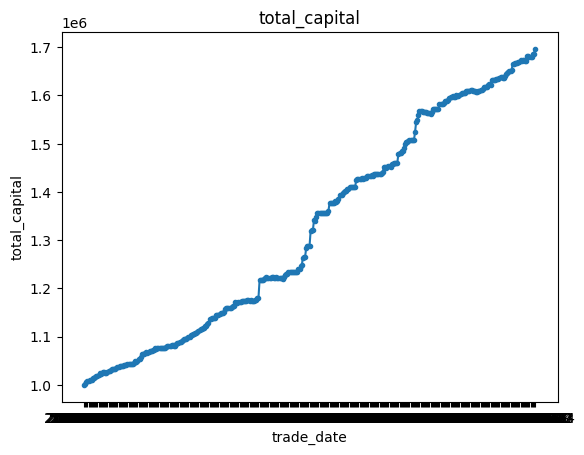

In [53]:
import matplotlib.pyplot as plt

# 示例 y 轴的值
y_values = total_capital_list

# 自动生成 x 轴的值
x_values = date_list

# 绘制折线图
plt.plot(x_values, y_values, marker='.')

# 设置标题和标签
plt.title("total_capital")
plt.xlabel("trade_date")
plt.ylabel("total_capital")

# 显示图表
plt.show()

In [54]:
a.orders

[('2023-01-04', 'BUY', '600547.SH', 64.0, 19.44, 124427.07302400001),
 ('2023-01-04', 'BUY', '603103.SH', 85.0, 14.59, 124026.037335),
 ('2023-01-04', 'BUY', '002244.SZ', 128.0, 9.71, 124299.06163200001),
 ('2023-01-04', 'BUY', '603517.SH', 21.0, 58.92, 123743.01214800001),
 ('2023-01-04', 'BUY', '002157.SZ', 299.0, 4.17, 124694.09678699999),
 ('2023-01-04', 'BUY', '002851.SZ', 47.0, 26.21, 123197.963643),
 ('2023-01-04', 'BUY', '600602.SH', 133.0, 9.35, 124366.067595),
 ('2023-01-04', 'BUY', '300012.SZ', 56.0, 22.12, 123883.024608),
 ('2023-01-04', 'SELL', '600547.SH', 64.0, 19.44, -84.35404799999378),
 ('2023-01-04', 'SELL', '603103.SH', 85.0, 14.59, -84.08216999997967),
 ('2023-01-04', 'SELL', '002244.SZ', 128.0, 9.72, 43.65734400000656),
 ('2023-01-04', 'SELL', '603517.SH', 21.0, 58.92, -83.89029599998321),
 ('2023-01-04', 'SELL', '002157.SZ', 299.0, 4.17, -84.53507399999944),
 ('2023-01-04', 'SELL', '002851.SZ', 47.0, 26.21, -83.52078599997913),
 ('2023-01-04', 'SELL', '600602.SH'